In [1]:
import torch

In [2]:
!nvidia-smi

Tue Apr  2 20:12:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 35%   44C    P0             46W /  200W |     479MiB /   8192MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import requests

# Get PDF document path

pdf_path = "human-nutrition-text.pdf"

# Download

if not os.path.exists(pdf_path):
    print(f"[INFO] PDF file doesn't exist, download...");

    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # The Local filename to save the downloaded file

    filename = pdf_path
    response = requests.get(url);

    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been dowloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File {pdf_path} exists")    



File human-nutrition-text.pdf exists


In [4]:
import fitz # requires: !pip install PyMuPDF
from tqdm.auto import tqdm # pip install tqdm

def text_formatter(text: str) -> str:
    """Performs mino formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # Potentially more text formatting functions can go here
    return cleaned_text;

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, # 1 token = ~4 characters
                                "text": text})
        
    return pages_and_texts;

pages_and_texts = open_and_read_pdf(pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [5]:
import random

random.sample(pages_and_texts, k = 3)

[{'page_number': 955,
  'page_char_count': 784,
  'page_word_count': 155,
  'page_sentence_count_raw': 6,
  'page_token_count': 196.0,
  'text': 'Image by  Allison  Calabrese /  CC BY 4.0  of glucose is used as well. Glucose differs from fatty acids where  glycogen storages can be depleted. As glycogen stores are depleted,  fatigue will eventually set in.  Figure 16.6 The Effect of Exercise Intensity on Fuel Sources  The Fat-Burning Zone  The fat-burning zone is a low intensity aerobic activity  that keeps your heart rate between 60 and 69% of your  maximum heart rate. The cardio zone on the other hand is  a high intensity aerobic activity that keeps the heart rate  between about 70 to 85% of your maximum heart rate. So  which zone do you burn the most fat in? Technically, your  body burns a higher percentage of of calories from fat  during a low intensity aerobic activity but there’s more to it  Fuel Sources  |  955'},
 {'page_number': 236,
  'page_char_count': 1108,
  'page_word_coun

In [6]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [7]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


In [8]:
from spacy.lang.en import English

nlp = English()

nlp.add_pipe("sentencizer")


for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    item["page_sentence_count_spacy"] = len(item["sentences"])



  0%|          | 0/1208 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': 938,
  'page_char_count': 1151,
  'page_word_count': 199,
  'page_sentence_count_raw': 9,
  'page_token_count': 287.75,
  'text': 'Image by  Cosmed /  CC BY-SA  3.0  Muscle Strength  Muscle strength is developed and maintained by weight or  resistance training that often is called anaerobic exercise. Anaerobic  exercise consists of short duration, high intensity movements that  rely on immediately available energy sources and require little or  no oxygen during the activity. This type of high intensity training  is used to build muscle strength by short, high intensity activities.  Building muscle mass is not just crucial for athletes and  bodybuilders—building muscle strength and endurance is important  for children, seniors, and everyone in between. The support that  your muscles provide allows you to work, play, and live more  efficiently. Strength training involves the use of resistance  machines, resistance bands, free weights, or other tools. However,  you do not

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


In [11]:
num_sentence_chunk_size = 10

def split_list(input_list: list[str], slice_size:int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

split_list(list(range(25)))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"], slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': 356,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': '',
  'sentences': [],
  'page_sentence_count_spacy': 0,
  'sentence_chunks': [],
  'num_chunks': 0}]

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


In [15]:
import re

pages_and_chunks = []

for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)


  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [16]:
random.sample(pages_and_chunks, k = 1)

[{'page_number': 165,
  'sentence_chunk': 'Regulation of Water Balance | 165',
  'chunk_char_count': 33,
  'chunk_word_count': 6,
  'chunk_token_count': 8.25}]

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


In [18]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 23.0 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=301 The Atom | 471
Chunk token count: 19.25 | Text: The function of the anticoagulant drug warfarin is 544 | Fat-Soluble Vitamins
Chunk token count: 4.5 | Text: 708 | Introduction
Chunk token count: 28.25 | Text: A concentration gradient is a form of potential energy, like water 172 | Electrolytes Important for Fluid Balance
Chunk token count: 16.5 | Text: PART X CHAPTER 10. MAJOR MINERALS Chapter 10. Major Minerals | 607


In [19]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [20]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 1152,
  'sentence_chunk': 'Nutrient RDA/ AIb (men / women) ages 31-50 Daily Value (Food Labels) ULc SUL or Guidance Leveld Selected Potential Effects of Excess Intake Vitamin A (mcg) 900 / 700 1500 (5000 IU) 3000 1500** (5000 IU) Liver damage, bone & joint pain, dry skin, loss of hair, headache, vomiting beta-Carotene (mg) – – – 7 (11,655 IU) Increased risk of lung cancer in smokers and those heavily exposed to asbestos Vitamin D (mcg) 15 (600 IU) 10 (400 IU) 100 25 (1000 IU) Calcification of brain, arteries, increased blood calcium, loss of appetite, nausea Vitamin E (mg) 15 20 (30 IU) 1000 540 (800 IU) Deficient blood clotting Vitamin K (mcg) 120 / 90* 80 – 1000** Red blood cell damage/anemia; liver damage Thiamin (B1) (mg) 1.2 / 1.1 1.5 – 100** Headache, nausea, irritability, insomnia, rapid pulse, weakness (7000+ mg dose) Riboflavin (B2) (mg) 1.3 / 1.1 1.7 – 40** Generally considered harmless; yellow discoloration of urine Niacin (mg) 16 / 14 20 35 500** Liver dama

In [21]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",device="cpu")

sentences = ["The Sentence Transformer library provides an easy way to create embeddings", "Sentences can be embeedded one by one or in a list.", "I like horses!"]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

Sentence: The Sentence Transformer library provides an easy way to create embeddings
Embedding: [-3.17511596e-02  3.37268598e-02 -2.52437927e-02  5.22287898e-02
 -2.35248730e-02 -6.19118195e-03  1.35026434e-02 -6.25500381e-02
  7.50828721e-03 -2.29684077e-02  2.98146289e-02  4.57554311e-02
 -3.26700546e-02  1.39847202e-02  4.18013670e-02 -5.92970550e-02
  4.26309966e-02  5.04661538e-03 -2.44552549e-02  3.98591766e-03
  3.55897881e-02  2.78741904e-02  1.84098370e-02  3.67700197e-02
 -2.29961090e-02 -3.01796645e-02  5.99534018e-04 -3.64503190e-02
  5.69104515e-02 -7.49939587e-03 -3.70004438e-02 -3.04354634e-03
  4.64353710e-02  2.36151251e-03  9.06849380e-07  7.00034108e-03
 -3.92289385e-02 -5.95695619e-03  1.38653023e-02  1.87109411e-03
  5.34202047e-02 -6.18613847e-02  2.19613463e-02  4.86050434e-02
 -4.25697602e-02 -1.69858932e-02  5.04178889e-02  1.54734347e-02
  8.12859908e-02  5.07106893e-02 -2.27497071e-02 -4.35721017e-02
 -2.18390999e-03 -2.14092191e-02 -2.01757699e-02  3.0683280

In [22]:
embeddings[0].shape

(768,)

In [23]:
embedding = embedding_model.encode('My favourite animal is the cow!')
embedding


array([-1.45472819e-02,  7.66727403e-02, -2.85872445e-02, -3.31283845e-02,
        3.65210250e-02,  4.78570461e-02, -7.08107427e-02,  1.62833892e-02,
        1.93443913e-02, -2.80482098e-02, -2.91747078e-02,  5.11309430e-02,
       -3.28720659e-02, -8.98755156e-03, -1.03672454e-02, -3.15488279e-02,
        4.22783792e-02, -9.13278013e-03, -1.94017179e-02,  4.35688719e-02,
       -2.31997631e-02,  4.29883003e-02, -1.72393788e-02, -2.01372579e-02,
       -3.13573964e-02,  8.08166154e-03, -2.06724983e-02, -2.27869563e-02,
        2.44812742e-02,  1.71968136e-02, -6.26672879e-02, -7.54796639e-02,
        3.57421972e-02, -5.46570402e-03,  1.24730320e-06, -7.63201574e-03,
       -3.53222154e-02,  1.91327240e-02,  3.99045683e-02,  2.11734185e-03,
        1.64566208e-02,  9.84051824e-03, -1.80700570e-02,  9.33829602e-03,
        3.23483571e-02,  5.84785677e-02,  4.23187464e-02,  1.62091944e-02,
       -9.14911404e-02,  1.82305165e-02, -5.25728893e-03, -7.81024154e-03,
       -3.47644500e-02, -

In [24]:
# %%time

# embedding_model.to("cpu")

# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"]  = embedding_model.encode(item["sentence_chunk"])

In [25]:
%%time

embedding_model.to("cuda")

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"]  = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: total: 1min 50s
Wall time: 19 s


In [26]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

len(text_chunks)

CPU times: total: 0 ns
Wall time: 0 ns


1680

In [27]:
%%time

text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)

text_chunk_embeddings

CPU times: total: 55.8 s
Wall time: 12.1 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [28]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"

text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [29]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242377e-02 9.02281404e-02 -5.09549072e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156344e-02 5.92139550e-02 -1.66167226e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79802009e-02 3.39813977e-02 -2.06426531e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566836e-02 3.81274670e-02 -8.46855342e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264531e-02 -8.49766750e-03 9.57159698e-...


In [30]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")
text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242377, 0.0902281404, -0.00509549072, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156344, 0.059213955, -0.0166167226, -0...."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279802009, 0.0339813977, -0.0206426531, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566836, 0.038127467, -0.00846855342, -0..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264531, -0.0084976675, 0.00957159698, -..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1304,186,326.00,"[0.0185622424, -0.0164277758, -0.0127045661, -..."
1676,1164,Hazard Analysis Critical Control Points reused...,374,51,93.50,"[0.03347205, -0.0570441037, 0.0151489377, -0.0..."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1285,175,321.25,"[0.0770515501, 0.00978559908, -0.012181744, 0...."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,63,102.50,"[0.103045151, -0.016470179, 0.00826844573, 0.0..."


In [31]:
embeddings.shape

torch.Size([1680, 768])

In [32]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

In [33]:
query = "good foods for protein"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds")

top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: good foods for protein
[INFO] Time taken to get scores on 1680 embeddings: 0.00038 seconds


torch.return_types.topk(
values=tensor([0.7729, 0.7647, 0.6743, 0.6743, 0.6634], device='cuda:0'),
indices=tensor([611, 616, 615, 620, 617], device='cuda:0'))

In [34]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(f"Text: {wrapped_text}")

In [35]:
print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")

Query: 'good foods for protein'

Results:
Score: 0.7729
Text: Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health. It’s the protein package that’s likely to make
a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins,
Diet, and Personal Choices | 411
Page number: 411
Score: 0.7647
Text: Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart disease.
Another tip is choosing to eat dry beans, peas, or soy products as a main dish.
Some of the menu choices include chili with kidney and pinto beans, hummus on
pita bread, and black bean enchiladas. You could also enjoy nuts in a variety of
way

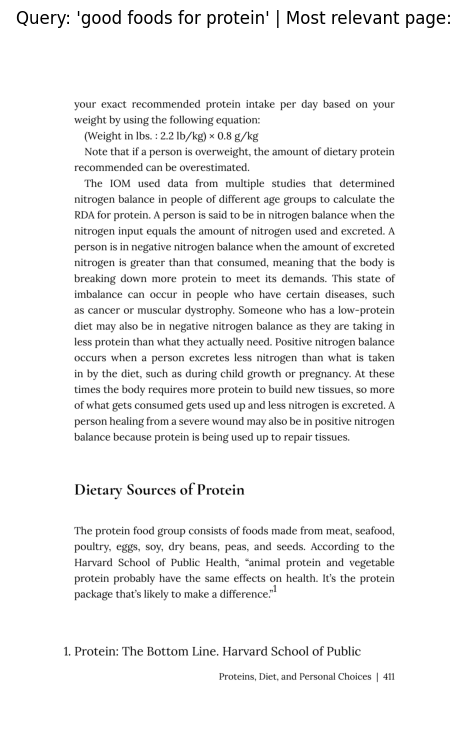

In [36]:
import fitz

pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(411 + 41)

img = page.get_pixmap(dpi=300)
img.save("output_filename.png")

doc.close()

img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))
img_array

import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show()

In [37]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)
    
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)


vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([1,2,3], dtype=torch.float32)
vector3 = torch.tensor([4,5,6], dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3], dtype=torch.float32)

print("Dot product between vector1 and vector2: ", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3: ", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4: ", dot_product(vector1, vector4))


print("Cosine similarity between vector1 and vector2: ", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3: ", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4: ", cosine_similarity(vector1, vector4))



Dot product between vector1 and vector2:  tensor(14.)
Dot product between vector1 and vector3:  tensor(32.)
Dot product between vector1 and vector4:  tensor(-14.)
Cosine similarity between vector1 and vector2:  tensor(1.0000)
Cosine similarity between vector1 and vector3:  tensor(0.9746)
Cosine similarity between vector1 and vector4:  tensor(-1.0000)


In [38]:
def retrieve_relevant_resources(query: str, embeddings: torch.tensor, model: SentenceTransformer=embedding_model, n_resources_to_return: int=5, print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    query_embedding = model.encode(query, convert_to_tensor=True)

    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)}) embeddings: {end_time-start_time:.5f} seconds")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Finds relevant passages given a query and pritns them out along with their scores.
    """

    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings, n_resources_to_return=n_resources_to_return)

    for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")

In [39]:
print_top_results_and_scores(query="foods high in fiber", embeddings=embeddings)

[INFO] Time taken to get scores on (1680) embeddings: 0.00003 seconds
Score: 0.7729
Text: Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health. It’s the protein package that’s likely to make
a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins,
Diet, and Personal Choices | 411
Page number: 411
Score: 0.7647
Text: Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart disease.
Another tip is choosing to eat dry beans, peas, or soy products as a main dish.
Some of the menu choices include chili with kidney and pinto beans, hummus on
pita bread, and black bean enchiladas. You could also en

In [40]:
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes/ 2**30)
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 8 GB


In [41]:
!nvidia-smi

Tue Apr  2 20:13:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 41%   52C    P5             41W /  200W |    2123MiB /   8192MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [42]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig

if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it")
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path="google/gemma-2b-it", 
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config,
                                                 low_cpu_mem_usage=False,
                                                 attn_implementation=attn_implementation)
  



[INFO] Using attention implementation: sdpa


tokenizer_config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [43]:
!nvidia-smi

Tue Apr  2 20:14:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 35%   41C    P5             21W /  200W |    3201MiB /   8192MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [44]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
     

In [45]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1515268096

In [46]:
def get_model_mem_size(model: torch.nn.Module):
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes, "model_mem_mb":round(model_mem_mb, 2), "model_mem_gb":round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2106740736, 'model_mem_mb': 2009.14, 'model_mem_gb': 1.96}

In [47]:
input_text = "What are the macronutriens, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

dialogue_template = [
    {
        "role":"user",
        "content":input_text
    }
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=True)

print(f"\nPrompt (formatted): \n{prompt}")

Input text:
What are the macronutriens, and what roles do they play in the human body?

Prompt (formatted): 
<bos><start_of_turn>user
What are the macronutriens, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [48]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	106: AddedToken("<start_of_turn>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	107: AddedToken("<end_of_turn>", rstrip=False, lstr

In [49]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = llm_model.generate(**input_ids, max_new_tokens=256)

print(f"Model output (tokens):\n{outputs[0]}\n")

c:\Git\simple-local-rag\venv\Lib\site-packages\transformers\models\gemma\modeling_gemma.py:561: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
          7208,    952, 235269,    578,   1212,  16065,    749,    984,   1554,
           575,    573,   3515,   2971, 235336,    107,    108,    106,   2516,
           108,  21404, 235269,   1517, 235303, 235256,    476,  25497,    576,
           573, 186809, 184592,    578,   1024,  16065,    575,    573,   3515,
          2971, 235292,    109,    688,  12298,   1695, 184592,  66058,    109,
        235287,   5231, 156615,  56227,  66058,   5626,   2971, 235303, 235256,
          7920,   4303,    576,   4134, 235269,   9151,   9719,    604,   5999,
           578,  29703, 235265,   2365,    708,   1942,    575,  16512,   1154,
         11843, 235269,  22512, 235269,  12463, 235269,  16803, 235269,    578,
         19574, 235265,    108, 235287,   5231,  49471,  66058,  47839,    604,
          4547,    578,  68808,  29703, 235269,   3547,  44760, 235269,  53186,
        235269,  

In [50]:
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutriens, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:** Our body's primary source of energy, providing fuel for cells and tissues. They are found in foods like bread, pasta, rice, fruits, and vegetables.
* **Protein:** Essential for building and repairing tissues, making enzymes, hormones, and antibodies. It is found in meat, fish, eggs, legumes, and nuts.
* **Fat:** Plays a crucial role in hormone production, cell signaling, and insulation. It is found in fats, oils, and some plant-based sources like avocado and nuts.

**Role of macronutrients in the body:**

* **Energy production:** Carbohydrates are broken down into glucose, which is used by cells for energy.
* **Building and repair:** Proteins are used to build and repair tissues, such as muscles, bones,

In [51]:
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [52]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How often should infants be breastfed?
[INFO] Time taken to get scores on (1680) embeddings: 0.00026 seconds


(tensor([0.6205, 0.6067, 0.5696, 0.5624, 0.5307], device='cuda:0'),
 tensor([1151, 1160, 1144, 1138, 1155], device='cuda:0'))

In [82]:
def prompt_formatter(query:str, context_items: list[dict]) -> str:
    
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    
    base_prompt = base_prompt.format(context=context, query=query)
    
    dialogue_template = [
        {"role":"user",
         "content":base_prompt}
    ]
    
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=True)
    
    return prompt

query = random.choice(query_list)

print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings, print_time=False)
context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query=query, context_items=context_items)
print(prompt)

Query: What are the macronutrients, and what roles do they play in the human body?
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.

Example 2:
Qu

In [83]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = llm_model.generate(**input_ids, temperature=0.7, do_sample=True, max_new_tokens=256)

output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer: \n{output_text.replace(prompt, '')}")

Query: What are the macronutrients, and what roles do they play in the human body?
RAG answer: 
<bos>Sure, here's an answer to the user's query based on the context:

The context provides a detailed explanation of macronutrients, including carbohydrates, lipids, and proteins. It explains that these nutrients are essential for the body to function properly and that they provide different forms of energy, contribute to tissue formation and repair, and facilitate various bodily processes.

**Carbohydrates** provide energy by providing a readily available source of quick energy. They are found in various foods, including grains, fruits, and vegetables.

**Lipids** are another important macronutrient that serves as a storage and energy source. They are found in animal products, plant oils, and some plant foods.

**Proteins** are essential for tissue formation and repair, hormone production, and enzyme creation. They are found in animal products, plant-based foods like beans and nuts, and so

In [86]:
def ask(query: str, temperature: float=0.7, max_new_tokens: int=256, format_answer_text=True, return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # RETRIEVAL
    
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings, print_time=False)
    context_items = [pages_and_chunks[i] for i in indices]
    
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()
        
    # AUGMENTATION 
    
    prompt = prompt_formatter(query=query, context_items=context_items)
    
    # GENERATION
    
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = llm_model.generate(**input_ids, temperature=temperature, do_sample=True, max_new_tokens=max_new_tokens)
    
    output_text = tokenizer.decode(outputs[0])
    
    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>","")
        
    if return_answer_only:
        return output_text
    
    return output_text, context_items
    
    

In [94]:
query = random.choice(query_list)
print(f"Query: {query}")

print(ask(query, temperature=0.2))

Query: What role does fibre play in digestion? Name five fibre containing foods.
Sure, here are the relevant passages from the context:

**Passage 1:**
> Fiber is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery.

**Passage 2:**
> Fiber is categorized as either water-soluble or insoluble. Some examples of soluble fibers are inulin, pectin, and guar gum and they are found in peas, beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a few dietary sources of them are whole-grain foods, flax, cauliflower, and avocados.

**Passage 3:**
> Fiber has been shown to provide health benefits to humans. Functional fibers have been added to foods and have been shown to provide health benefits to humans. Functional fibers may be extracted from plants and purified